## Create a test and train image generator using the dataset. 

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_sample_weight
import numpy as np

data = 'archive/Garbage classification/Garbage classification'
batch_size = 100 # Leads to around 20 batches
target_size = (128, 96) # This is 1/3 the image shape

train = ImageDataGenerator(horizontal_flip=True, vertical_flip=True,validation_split=0.1,rescale=1./255,
                         shear_range = 0.1,zoom_range = 0.1,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,)

test =ImageDataGenerator(rescale=1./255,validation_split=0.1)

train_generator = train.flow_from_directory(
    data,
    target_size=(128, 96),
    batch_size=batch_size,
    class_mode='categorical',
    subset = 'training'
)

test_generator = test.flow_from_directory(
    data,
    target_size=(128, 96),
    batch_size=batch_size,
    class_mode='categorical',
    subset = 'validation'
)

class_labels = list(train_generator.class_indices.keys())
print(class_labels)

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


## Model creation
- parameters allow for different numbers of layers, convolutional filters, learning rate, l1/l2 regularization and dropout.

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import models, layers
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.layers import BatchNormalization

def create_model(learning_rate=1e-3, l1_reg=0.0, l2_reg=0.0, dropout_rate=0.0):
    labels = list(train_generator.class_indices.keys())
    num_classes = len(labels)
    model = models.Sequential()

    model.add(layers.Conv2D(8, (3, 3), padding='same', input_shape=(128, 96, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(16,(3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))

    model.add(layers.Conv2D(32,(3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg)))
    model.add(Dropout(dropout_rate))
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg)))
    model.add(Dropout(dropout_rate))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=[tf.keras.metrics.CategoricalAccuracy()])

    checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

    return model



After testing different parameters, we chose to apply dropout, batch normalization, and l1/l2 regularization to prevent overfitting. 

Train the model, with parameters as determined to be optimum for the model. Early stopping is applied.

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=20, mode='min', verbose=1, restore_best_weights=True)
final_model = create_model(.001, .001, .001, .15)
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = final_model.fit(train_generator, epochs=200, validation_data=test_generator, callbacks=[checkpoint, early_stop])

Epoch 1/200
23/23 [==============================] - ETA: 0s - loss: 75.4422 - categorical_accuracy: 0.3967
Epoch 1: val_loss improved from inf to 49.21300, saving model to best_model.h5
23/23 [==============================] - 21s 839ms/step - loss: 75.4422 - categorical_accuracy: 0.3967 - val_loss: 49.2130 - val_categorical_accuracy: 0.2311
Epoch 2/200


/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


23/23 [==============================] - ETA: 0s - loss: 31.6092 - categorical_accuracy: 0.4846
Epoch 2: val_loss improved from 49.21300 to 18.64299, saving model to best_model.h5
23/23 [==============================] - 21s 901ms/step - loss: 31.6092 - categorical_accuracy: 0.4846 - val_loss: 18.6430 - val_categorical_accuracy: 0.3028
Epoch 3/200
23/23 [==============================] - ETA: 0s - loss: 12.3034 - categorical_accuracy: 0.5435
Epoch 3: val_loss improved from 18.64299 to 8.64432, saving model to best_model.h5
23/23 [==============================] - 23s 979ms/step - loss: 12.3034 - categorical_accuracy: 0.5435 - val_loss: 8.6443 - val_categorical_accuracy: 0.2072
Epoch 4/200
23/23 [==============================] - ETA: 0s - loss: 6.5177 - categorical_accuracy: 0.5417
Epoch 4: val_loss improved from 8.64432 to 6.01414, saving model to best_model.h5
23/23 [==============================] - 19s 813ms/step - loss: 6.5177 - categorical_accuracy: 0.5417 - val_loss: 6.0141 - va

Epoch 27/200
23/23 [==============================] - ETA: 0s - loss: 2.1130 - categorical_accuracy: 0.6986
Epoch 27: val_loss did not improve from 3.21257
23/23 [==============================] - 18s 768ms/step - loss: 2.1130 - categorical_accuracy: 0.6986 - val_loss: 3.4138 - val_categorical_accuracy: 0.3147
Epoch 28/200
23/23 [==============================] - ETA: 0s - loss: 2.1408 - categorical_accuracy: 0.6964
Epoch 28: val_loss did not improve from 3.21257
23/23 [==============================] - 17s 743ms/step - loss: 2.1408 - categorical_accuracy: 0.6964 - val_loss: 4.1186 - val_categorical_accuracy: 0.2908
Epoch 29/200
23/23 [==============================] - ETA: 0s - loss: 2.0858 - categorical_accuracy: 0.6973
Epoch 29: val_loss improved from 3.21257 to 2.78164, saving model to best_model.h5
23/23 [==============================] - 18s 786ms/step - loss: 2.0858 - categorical_accuracy: 0.6973 - val_loss: 2.7816 - val_categorical_accuracy: 0.4502
Epoch 30/200
23/23 [=========

23/23 [==============================] - 18s 778ms/step - loss: 1.8598 - categorical_accuracy: 0.7570 - val_loss: 2.2435 - val_categorical_accuracy: 0.6853
Epoch 53/200
23/23 [==============================] - ETA: 0s - loss: 1.8969 - categorical_accuracy: 0.7478
Epoch 53: val_loss did not improve from 2.04717
23/23 [==============================] - 18s 759ms/step - loss: 1.8969 - categorical_accuracy: 0.7478 - val_loss: 2.0838 - val_categorical_accuracy: 0.7410
Epoch 54/200
23/23 [==============================] - ETA: 0s - loss: 1.9042 - categorical_accuracy: 0.7482
Epoch 54: val_loss did not improve from 2.04717
23/23 [==============================] - 18s 755ms/step - loss: 1.9042 - categorical_accuracy: 0.7482 - val_loss: 2.8359 - val_categorical_accuracy: 0.4661
Epoch 55/200
23/23 [==============================] - ETA: 0s - loss: 1.8807 - categorical_accuracy: 0.7544
Epoch 55: val_loss did not improve from 2.04717
23/23 [==============================] - 18s 781ms/step - loss: 

In [22]:
# Save model for prediction
import joblib 

filename = 'model1.sav'
joblib.dump(final_model, filename)

['model1.sav']

In [23]:
import pickle

# Saving history to a file
with open('training_history.pkl', 'wb') as file:
    pickle.dump(history, file)


Found 251 images belonging to 6 classes.
3/3 [==============================] - 1s 208ms/step
Confusion Matrix:
[[27  0  6  4  2  1]
 [ 0 25 12  5  7  1]
 [ 1  0 37  1  2  0]
 [ 1  0  0 57  1  0]
 [ 0  2 10  5 28  3]
 [ 0  1  1  0  0 11]]


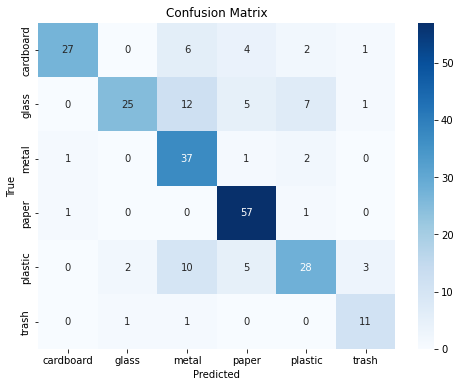

In [24]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import numpy as np

test_set = test.flow_from_directory(
    data,
    target_size=(128, 96),
    batch_size=batch_size,
    class_mode='categorical',
    subset = 'validation',
    shuffle = False
)

predictions = final_model.predict(test_set)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

confusion_mat = confusion_matrix(true_classes, predicted_classes)

print("Confusion Matrix:")
print(confusion_mat)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [35]:
# Get classification report
from sklearn.metrics import classification_report

print(classification_report(true_classes, predicted_classes, target_names=list(test_generator.class_indices.keys())))


              precision    recall  f1-score   support

   cardboard       0.93      0.68      0.78        40
       glass       0.89      0.50      0.64        50
       metal       0.56      0.90      0.69        41
       paper       0.79      0.97      0.87        59
     plastic       0.70      0.58      0.64        48
       trash       0.69      0.85      0.76        13

    accuracy                           0.74       251
   macro avg       0.76      0.75      0.73       251
weighted avg       0.77      0.74      0.73       251



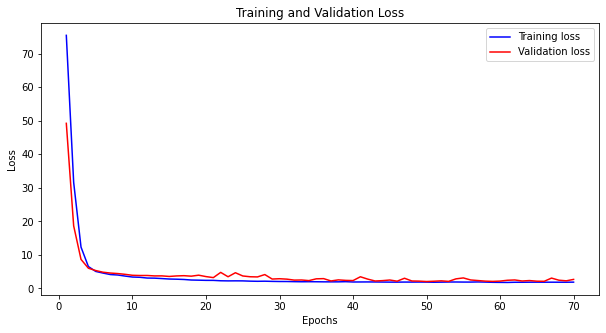

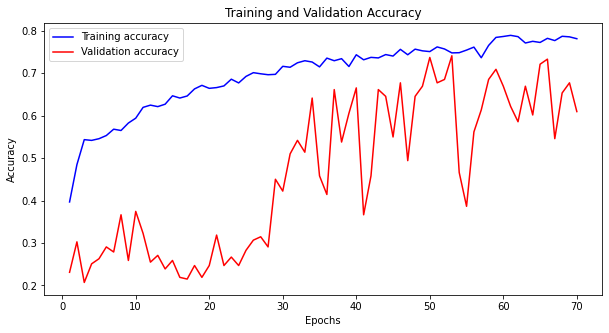

In [31]:
# Plotting training and validation loss
import matplotlib.pyplot as plt
import math

with open('training_history.pkl', 'rb') as file:
    history = pickle.load(file)
    
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
